# 長距離伝送シミュレーションを行う

In [1]:
#import
import sys
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

sys.path.append('../')
from pyopt import modulate as md
from pyopt import transmission as tr
from pyopt.util import fft, ifft, save_pickle, load_pickle, sampling_signal

# 1. PRBS信号を伝送する

## 1.1 PRBS信号を生成する

In [2]:
N = 17  # PRBSの次数
itr = 1  # PRBSの繰り返し回数

In [3]:
bitsq = md.prbs(N=N, itr=itr)

#print('ビット列: ', bitsq[:128])
print('ビット長: ', bitsq.shape)

ビット長:  (131072,)


## 1.2 PRBS信号を変調する

In [4]:
form = 'RZ16QAM'  # 変調方式
n = 32  # 1シンボルあたりのサンプリング数[/symbol]
equalize = False  # 各シンボル数を均等にするか

In [5]:
mdl = md.Modulate(form=form, n=n, equalize=equalize)
modsq = mdl.transform(bitsq)

#print('シンボル列: ', modsq[:40])
print('シンボル長: ', modsq.shape)

rz16QAM modulation START
シンボル長:  (1048576,)


In [6]:
sampling = 2

modsq_sampled = sampling_signal(modsq, n, sampling)

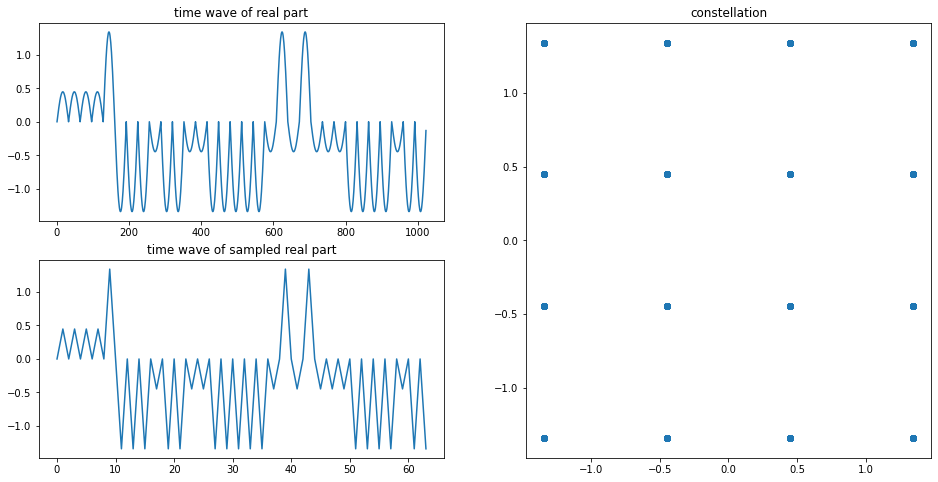

In [7]:
# 可視化 時間領域
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(1, 2, 2)

ax1.plot(modsq[:n * 32].real)
ax1.set_title('time wave of real part')

ax2.plot(modsq_sampled[:sampling * 32].real)
ax2.set_title('time wave of sampled real part')

ax3.plot(modsq[int(n/2):: n].real, modsq[int(n/2):: n].imag, 'o')
ax3.set_title('constellation');

(1048576,)
(524288,)


Text(0.5, 1.0, 'frequency domain')

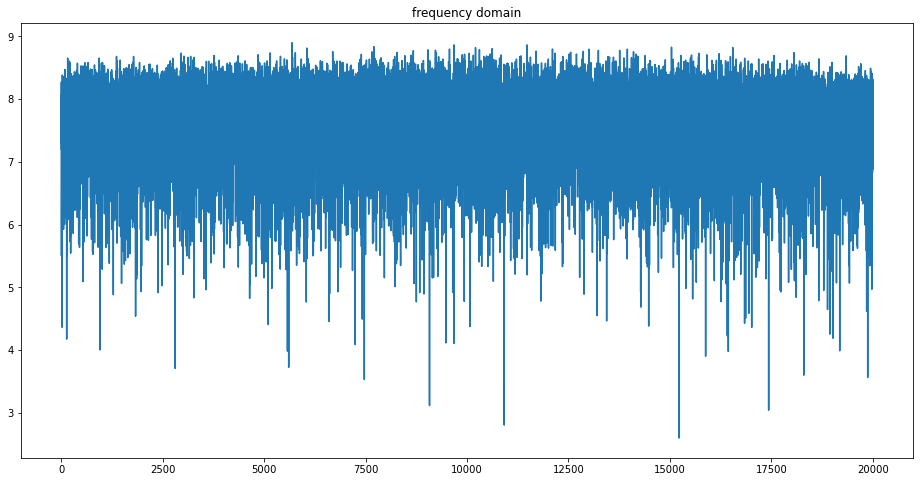

In [51]:
# 可視化 周波数領域
MODSQ = fft(modsq[::2])

print(modsq.shape)
print(MODSQ.shape)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
a = 10000
ax.plot(np.log(abs(MODSQ[len(MODSQ) // 2 - a: len(MODSQ) // 2 + a])))
ax.set_title('frequency domain')

## 1.3 16QAM変調されたPRBS信号を伝送する

In [9]:
baudrate = 28  # ボーレート[GBaud]
PdBm = 1  # 平均入力光パワー[dBm]
Ledfa = 100  # EDFAスパン[km]
stepedfa = 30  # SSFMの繰り返し計算ステップ数
gamma = 1.4  # 非線形係数[/W/km]
D = 16  # 分散パラメータ[ps/nm/km]
Alpha = 0.16  # 伝送損失[dB/km]
NF = 4  # ASE雑音指数[dB]

Lmax = 500  # 伝送距離[km]
ase = True  # ASE雑音を考慮するか

In [10]:
sgnl = tr.Signal(seq=modsq, form=form, n=n, baudrate=baudrate, PdBm=PdBm, Ledfa=Ledfa, stepedfa=stepedfa,
                           gamma=gamma, D=D, Alpha=Alpha, NF=NF)
sgnl.transmission(Lmax=Lmax, ase=ase)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [12:43<00:00, 152.68s/it]


In [11]:
signal_in = sgnl.signal['x_0']
signal_in_sampled = signal_in[int(n/2)::n]
signal = sgnl.signal['x_500']
signal_sampled = signal[int(n/2)::n]
signal_lc = sgnl.linear_compensation(Lmax, sgnl.signal['x_500'])
signal_lc_sampled = signal_lc[int(n/2)::n]

print('位相回転量(理論値): ', sgnl.phase_rotation_theo(Lmax))
print('位相回転量(シミュレーション値): ', sgnl.phase_rotation_simu(Lmax, signal_lc_sampled))
print('EVM(補償無し): ', sgnl.cal_evm(Lmax, signal_sampled))
print('EVM(100%線形補償): ', sgnl.cal_evm(Lmax, signal_lc_sampled))
print('EVM(100%線形補償+位相回転補償): ', sgnl.cal_evm_pr(Lmax, signal_lc_sampled))
print('BER(100%線形補償): ', sgnl.cal_ber(Lmax, signal_lc_sampled))
print('Q値(100%線形補償): ', sgnl.cal_qfac(Lmax, signal_lc_sampled))

位相回転量(理論値):  26.721858714928224
位相回転量(シミュレーション値):  27.140533054780256
EVM(補償無し):  138.12119141287587
EVM(100%線形補償):  47.47420292936796
EVM(100%線形補償+位相回転補償):  7.122074041686884
BER(100%線形補償):  0.12981956927943622
Q値(100%線形補償):  1.0403621726607246


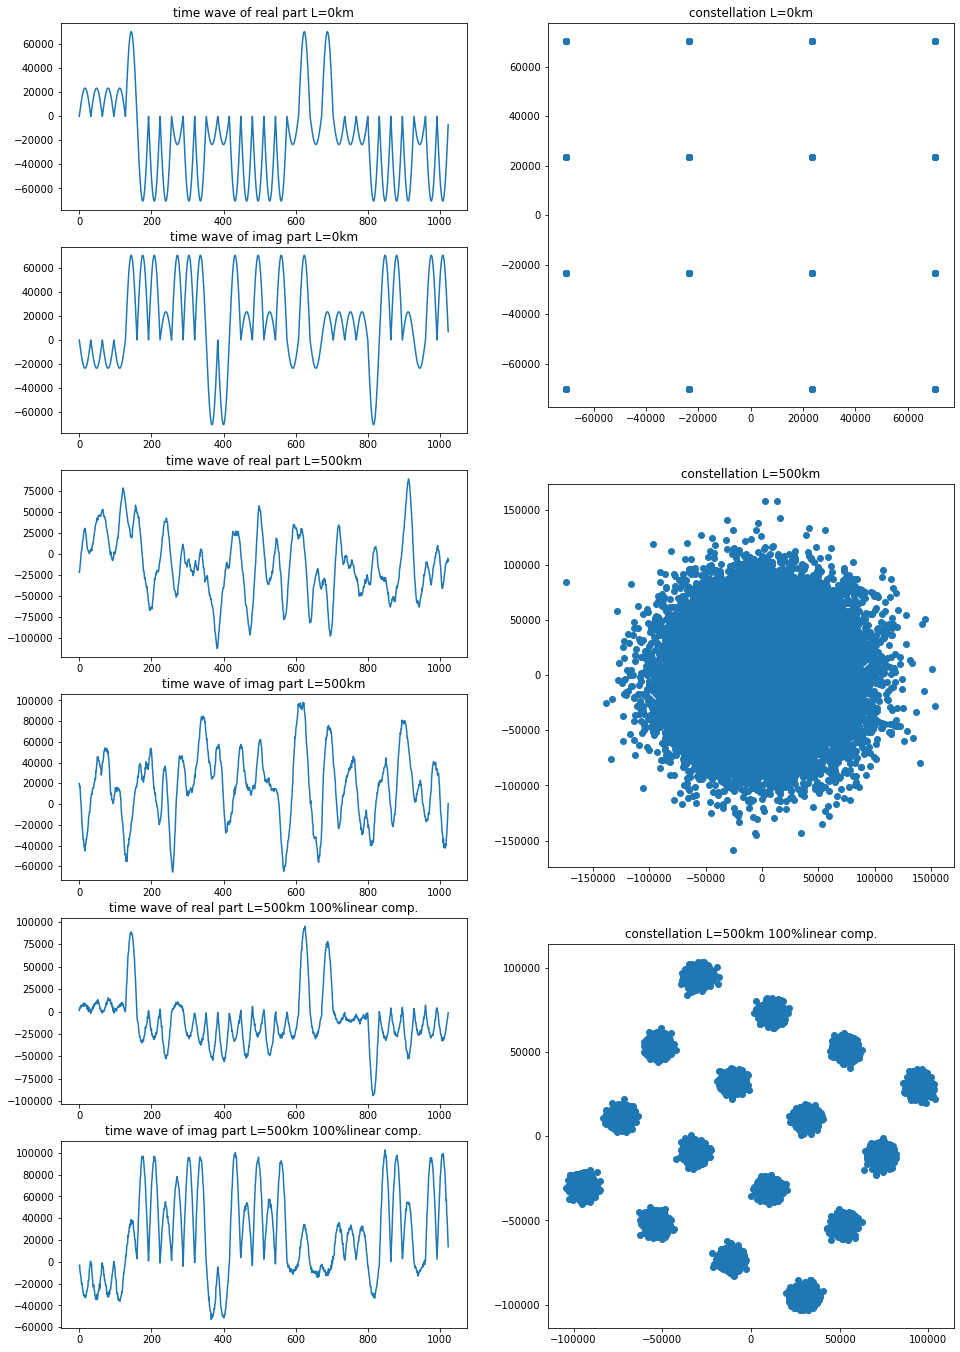

In [12]:
# 可視化 時間領域
fig = plt.figure(figsize=(16, 24))
ax1 = fig.add_subplot(6, 2, 1)
ax2 = fig.add_subplot(6, 2, 3)
ax3 = fig.add_subplot(3, 2, 2)
ax4 = fig.add_subplot(6, 2, 5)
ax5 = fig.add_subplot(6, 2, 7)
ax6 = fig.add_subplot(3, 2, 4)
ax7 = fig.add_subplot(6, 2, 9)
ax8 = fig.add_subplot(6, 2, 11)
ax9 = fig.add_subplot(3, 2, 6)

ax1.plot(signal_in[:32 * n].real)
ax1.set_title('time wave of real part L=0km')
ax2.plot(signal_in[:32 * n].imag)
ax2.set_title('time wave of imag part L=0km')
ax3.plot(signal_in_sampled.real, signal_in_sampled.imag, 'o')
ax3.set_title('constellation L=0km')

ax4.plot(signal[:32 * n].real)
ax4.set_title('time wave of real part L=500km')
ax5.plot(signal[:32 * n].imag)
ax5.set_title('time wave of imag part L=500km')
ax6.plot(signal_sampled.real, signal_sampled.imag, 'o')
ax6.set_title('constellation L=500km')

ax7.plot(signal_lc[:32 * n].real)
ax7.set_title('time wave of real part L=500km 100%linear comp.')
ax8.plot(signal_lc[:32 * n].imag)
ax8.set_title('time wave of imag part L=500km 100%linear comp.')
ax9.plot(signal_lc_sampled.real, signal_lc_sampled.imag, 'o')
ax9.set_title('constellation L=500km 100%linear comp.');

Text(0.5, 1.0, 'frequency domain')

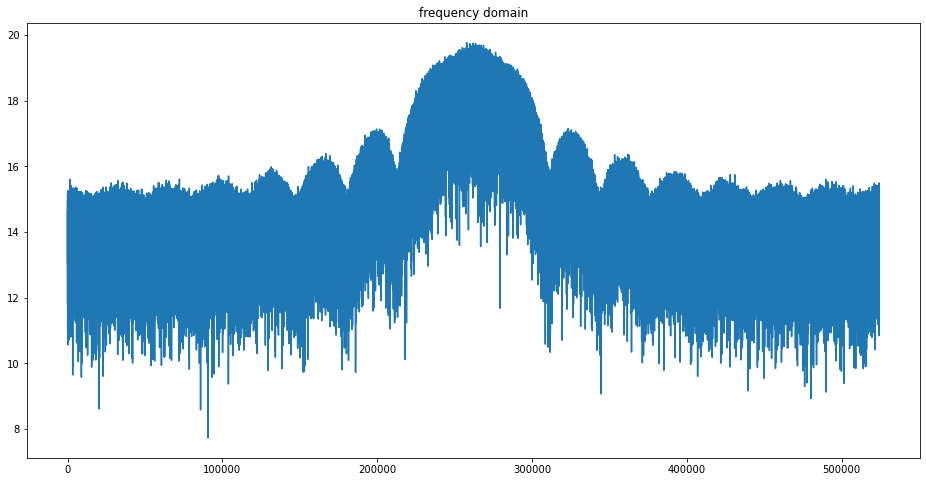

In [14]:
#可視化 周波数領域
signal_sampled = sampling_signal(signal, n, 16)
SIGNAL = fft(signal_sampled)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.log(abs(SIGNAL)))
ax.set_title('frequency domain')

## PRBS信号 伝送&dataframe追加

In [2]:
def prbs_transmission(PdBm, N):
    #N = 17  # PRBSの次数
    itr = 1  # PRBSの繰り返し回数
    form = 'RZ16QAM'  # 変調方式
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    #PdBm = 1  # 平均入力光パワー[dBm]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    Lmax = 2500  # 伝送距離[km]
    ase = False  # ASE雑音を考慮するか

    df_dir = '../data/input/prbs.csv'
    if os.path.exists(df_dir):
        df = pd.read_csv(df_dir, index_col=0)
    else:
        cols = ['N', 'itr', 'form', 'n', 'equalize', 'baudrate', 'PdBm', 'Ledfa', 'stepedfa', 'gamma', 'D', 'Alpha', 'NF', 'Lmax', 'ase', 'data_path']
        df = pd.DataFrame(index=[], columns=cols)

    condition = (df['N']==N) & (df['itr']==itr) & (df['form']==form) & (df['n']==n) & (df['equalize']==equalize) & (df['baudrate']==baudrate) & \
                         (df['PdBm']==PdBm) & (df['Ledfa']==Ledfa) & (df['stepedfa']==stepedfa) & (df['gamma']==gamma) & (df['D']==D) & \
                         (df['Alpha']==Alpha) & (df['NF']==NF) & (df['ase']==ase)
    if sum(condition) > 0:
        index = df[condition].index[0]
        if df['Lmax'][index] >= Lmax:
            print('指定された条件の伝送データはすでに存在します')
        else:
            data_path = df['data_path'][index]
            sgnl = load_pickle(data_path)
            sgnl.transmission(Lmax=Lmax, ase=ase)
            save_pickle(sgnl, data_path)

            df.loc[index, 'Lmax'] = Lmax
            df.to_csv(df_dir)
    else:
        data_path = '../data/input/prbs/prbs_' + str(len(df)).zfill(10) + '.pickle'
        bitsq = md.prbs(N=N, itr=itr)
        mdl = md.Modulate(form=form, n=n, equalize=equalize)
        modsq = mdl.transform(bitsq)
        sgnl = tr.Signal(seq=modsq, form=form, n=n, baudrate=baudrate, PdBm=PdBm, Ledfa=Ledfa, stepedfa=stepedfa,
                                   gamma=gamma, D=D, Alpha=Alpha, NF=NF)
        sgnl.transmission(Lmax=Lmax, ase=ase)
        save_pickle(sgnl, data_path)

        sr = pd.Series([N, itr, form, n, equalize, baudrate, PdBm, Ledfa, stepedfa, gamma, D, Alpha, NF, Lmax, ase, data_path], index=df.columns)
        df = df.append(sr, ignore_index=True)
        df.to_csv(df_dir)

In [3]:
#for N in [13, 14, 15, 16, 17]:
#    for PdBm in [-2, -1, 0, 1, 2, 3]:
prbs_transmission(1, 13)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.64s/it]


# 2. Random信号を伝送する

## 2.1 Random信号を生成する

In [12]:
seed = 1234  # 乱数シード
bit_num = 128  # ビット長を指定

In [13]:
np.random.seed(seed=seed)
ransq = np.random.randint(0, 2, bit_num)

print('ビット列: ', ransq)
print('ビット長: ', ransq.shape)

ビット列:  [1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0
 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 1 1
 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0 1
 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0]
ビット長:  (128,)


## Random信号 伝送&dataframe追加

In [5]:
def random_transmission(PdBm):
    seed = 7777  # 乱数シード
    bit_num = 10000  # ビット長を指定
    form = 'RZ16QAM'  # 変調方式
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    # PdBm = 1  # 平均入力光パワー[dBm]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    Lmax = 5000  # 伝送距離[km]
    ase = True  # ASE雑音を考慮するか

    df_dir = '../data/input/random.csv'
    if os.path.exists(df_dir):
        df = pd.read_csv(df_dir, index_col=0)
    else:
        cols = ['seed', 'bit_num', 'form', 'n', 'equalize', 'baudrate', 'PdBm', 'Ledfa', 'stepedfa', 'gamma', 'D', 'Alpha', 'NF', 'Lmax', 'ase', 'data_path']
        df = pd.DataFrame(index=[], columns=cols)

    condition = (df['seed']==seed) & (df['bit_num']==bit_num) & (df['form']==form) & (df['n']==n) & (df['equalize']==equalize) & (df['baudrate']==baudrate) & \
                         (df['PdBm']==PdBm) & (df['Ledfa']==Ledfa) & (df['stepedfa']==stepedfa) & (df['gamma']==gamma) & (df['D']==D) & \
                         (df['Alpha']==Alpha) & (df['NF']==NF) & (df['ase']==ase)
    if sum(condition) > 0:
        index = df[condition].index[0]
        if df['Lmax'][index] >= Lmax:
            print('指定された条件の伝送データはすでに存在します')
        else:
            data_path = df['data_path'][index]
            sgnl = load_pickle(data_path)
            sgnl.transmission(Lmax=Lmax, ase=ase)
            save_pickle(sgnl, data_path)

            df.loc[index, 'Lmax'] = Lmax
            df.to_csv(df_dir)
    else:
        data_path = '../data/input/random/random_' + str(len(df)).zfill(10) + '.pickle'
        np.random.seed(seed=seed)
        ransq = np.random.randint(0, 2, bit_num)
        mdl = md.Modulate(form=form, n=n, equalize=equalize)
        modsq = mdl.transform(ransq)
        sgnl = tr.Signal(seq=modsq, form=form, n=n, baudrate=baudrate, PdBm=PdBm, Ledfa=Ledfa, stepedfa=stepedfa,
                                   gamma=gamma, D=D, Alpha=Alpha, NF=NF)
        sgnl.transmission(Lmax=Lmax, ase=ase)
        save_pickle(sgnl, data_path)

        sr = pd.Series([seed, bit_num, form, n, equalize, baudrate, PdBm, Ledfa, stepedfa, gamma, D, Alpha, NF, Lmax, ase, data_path], index=df.columns)
        df = df.append(sr, ignore_index=True)
        df.to_csv(df_dir)


In [6]:
for PdBm in [1]:
    random_transmission(PdBm)

rz16QAM modulation START


  4%|█████████                                                                                                                                                                                                                           | 2/50 [00:25<10:12, 12.77s/it]


KeyboardInterrupt: 

# 3. Image信号を伝送する

## 3.1 Image信号を生成する

In [15]:
target_dir = 'train_0'
step = 10  # (768, 1024) ---> (76, 102)
image_number = 0
ebtb = False  # 8B10Bを行うか

In [16]:
image_dir = '../data/image/'
image_path_list = sorted(glob.glob(os.path.join(image_dir + target_dir, '*.jpg')))
image_path = image_path_list[image_number]
print(image_path)

../data/image/train\dec2aafe511bcd90.jpg


画像サイズ:  (768, 1024, 3)


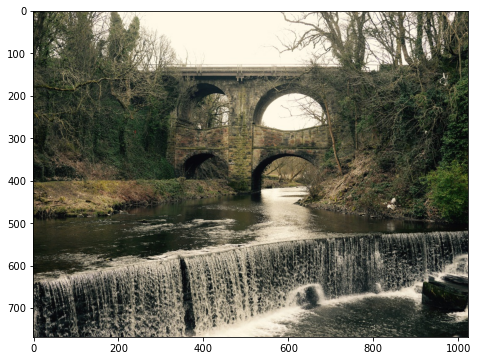

In [17]:
img = Image.open(image_path)
img_array = np.array(img)
print('画像サイズ: ', img_array.shape)

fig = plt.figure(figsize=(9, 6))
plt.imshow(img);

In [18]:
imgsq = img_array[::step, ::step].reshape(-1)

print('配列: ', imgsq)
print('配列長: ', imgsq.shape)

配列:  [79 72 17 ...  9 11 10]
配列長:  (23793,)


In [19]:
if ebtb:
    imgsq_binary = md.eightb_tenb(imgsq)
else:
    imgsq_binary = md.image_to_binary(imgsq)

print('ビット列: ', imgsq_binary[:128])
print('ビット長: ', imgsq_binary.shape)

 20%|██████████████████████████                                                                                                          | 4707/23793 [00:00<00:00, 46613.28it/s]

image to binary START


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23793/23793 [00:00<00:00, 47223.62it/s]

ビット列:  [0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1
 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0
 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1]
ビット長:  (190344,)


## Image信号 伝送&dataframe追加

In [2]:
def image_transmission(image_number, PdBm):
    target_dir = 'train_0'
    step = 60  # =10 ---> (768, 1024) ---> (76, 102)
    #image_number = 4
    ebtb = True  # 8B10Bを行うか
    form = 'RZ16QAM'  # 変調方式
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    #PdBm = 1  # 平均入力光パワー[dBm]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    Lmax = 5000  # 伝送距離[km]
    ase = True  # ASE雑音を考慮するか

    df_dir = '../data/input/image.csv'
    if os.path.exists(df_dir):
        df = pd.read_csv(df_dir, index_col=0)
    else:
        cols = ['target_dir', 'step', 'image_number', 'ebtb',
                    'form', 'n', 'equalize', 'baudrate', 'PdBm', 'Ledfa', 'stepedfa', 'gamma', 'D', 'Alpha', 'NF', 'Lmax', 'ase', 'data_path']
        df = pd.DataFrame(index=[], columns=cols)

    condition = (df['target_dir']==target_dir) & (df['step']==step) & (df['image_number']==image_number) & (df['ebtb']==ebtb) & (df['form']==form) & \
                         (df['n']==n) & (df['equalize']==equalize) & (df['baudrate']==baudrate) & (df['PdBm']==PdBm) & (df['Ledfa']==Ledfa) & \
                         (df['stepedfa']==stepedfa) & (df['gamma']==gamma) & (df['D']==D) & (df['Alpha']==Alpha) & (df['NF']==NF) & (df['ase']==ase)
    if sum(condition) > 0:
        index = df[condition].index[0]
        if df['Lmax'][index] >= Lmax:
            print('指定された条件の伝送データはすでに存在します')
        else:
            data_path = df['data_path'][index]
            sgnl = load_pickle(data_path)
            sgnl.transmission(Lmax=Lmax, ase=ase)
            save_pickle(sgnl, data_path)

            df.loc[index, 'Lmax'] = Lmax
            df.to_csv(df_dir)
    else:        
        data_path = '../data/input/image/image_' + str(len(df)).zfill(10) + '.pickle'
        image_dir = '../data/image/'
        image_path_list = sorted(glob.glob(os.path.join(image_dir + target_dir, '*.jpg')))
        image_path = image_path_list[image_number]
        img = Image.open(image_path)
        img_array = np.array(img)
        imgsq = img_array[::step, ::step].reshape(-1)
        if ebtb:
            imgsq_binary = md.eightb_tenb(imgsq)
        else:
            imgsq_binary = md.image_to_binary(imgsq)

        mdl = md.Modulate(form=form, n=n, equalize=equalize)
        modsq = mdl.transform(imgsq_binary)
        sgnl = tr.Signal(seq=modsq, form=form, n=n, baudrate=baudrate, PdBm=PdBm, Ledfa=Ledfa, stepedfa=stepedfa,
                                   gamma=gamma, D=D, Alpha=Alpha, NF=NF)
        sgnl.transmission(Lmax=Lmax, ase=ase)
        save_pickle(sgnl, data_path)

        sr = pd.Series([target_dir, step, image_number, ebtb,
                                   form, n, equalize, baudrate, PdBm, Ledfa, stepedfa, gamma, D, Alpha, NF, Lmax, ase, data_path, image_path], index=df.columns)
        df = df.append(sr, ignore_index=True)
        df.to_csv(df_dir)

In [3]:
for num in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 17, 33, 35, 45, 52, 53]:
    for PdBm in [-2, -1, 0, 1, 2, 3]:
        image_transmission(num, PdBm)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 972/972 [00:00<00:00, 14023.19it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 972/972 [00:00<00:00, 13824.42it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 972/972 [00:00<00:00, 11088.80it/s]


rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [07:09<00:00,  8.60s/it]


指定された条件の伝送データはすでに存在します


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 972/972 [00:00<00:00, 10943.10it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 972/972 [00:00<00:00, 15247.96it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 14979.05it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 22472.92it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 14979.20it/s]


rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:50<00:00,  4.61s/it]


指定された条件の伝送データはすでに存在します


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 22438.32it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 11226.86it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 20740.75it/s]


rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 9639.03it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 13827.16it/s]


rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:27<00:00,  4.15s/it]


指定された条件の伝送データはすでに存在します


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 20742.65it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 13828.50it/s]


rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 14979.43it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 14969.45it/s]


rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:23<00:00,  4.08s/it]


指定された条件の伝送データはすでに存在します


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 22434.39it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 11234.49it/s]


rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 20742.80it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 11776.29it/s]


rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:02<00:00,  3.64s/it]


指定された条件の伝送データはすでに存在します


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 11226.65it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 14979.20it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 22441.06it/s]


rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:21<00:00,  4.03s/it]


指定された条件の伝送データはすでに存在します


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


指定された条件の伝送データはすでに存在します


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 13826.74it/s]


rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:00<00:00,  3.62s/it]


指定された条件の伝送データはすでに存在します


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 20740.43it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 13678.52it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 22434.90it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 15008.60it/s]


rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 8987.66it/s]


rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:41<00:00,  4.44s/it]


指定された条件の伝送データはすでに存在します


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 11234.83it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 22468.11it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 13827.59it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 20740.11it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 20740.91it/s]


rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:23<00:00,  4.08s/it]


指定された条件の伝送データはすでに存在します


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 13439.36it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 10369.94it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 10369.74it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 13349.85it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 13828.01it/s]


rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:21<00:00,  4.03s/it]


指定された条件の伝送データはすでに存在します


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 10927.32it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 20740.11it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 594/594 [00:00<00:00, 12674.58it/s]


rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 594/594 [00:00<00:00, 18987.43it/s]


rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:04<00:00,  3.69s/it]


指定された条件の伝送データはすでに存在します


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 594/594 [00:00<00:00, 19007.56it/s]


rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 14978.97it/s]


rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:17<00:00,  3.95s/it]


指定された条件の伝送データはすでに存在します


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 22467.26it/s]


rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 22434.22it/s]


rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:16<00:00,  3.92s/it]


指定された条件の伝送データはすでに存在します


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 14978.67it/s]


rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 10041.89it/s]


rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:54<00:00,  3.48s/it]


指定された条件の伝送データはすでに存在します


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 10370.25it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 20739.48it/s]


rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.18s/it]


指定された条件の伝送データはすでに存在します


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 20736.95it/s]


rz16QAM modulation START


  0%|                                                                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 12385.83it/s]


rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:27<00:00,  4.15s/it]


指定された条件の伝送データはすでに存在します


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 20743.44it/s]


rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 7805.64it/s]


rz16QAM modulation START


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:18<00:00,  3.97s/it]
